In [190]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2, l1

from sklearn.metrics import accuracy_score, precision_score

## EDA

In [164]:
data = pd.read_csv('movie_statistic_dataset.csv')
data.head()

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.0,James Cameron,"writer,producer,director",1954,alive,7.8,277543.0,7.061101,460000000,667830256,2265935552
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.0,-,-,-,-,8.4,1143642.0,8.489533,400000000,858373000,2794731755
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.0,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.6,533763.0,6.272064,379000000,241071802,1045713802
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.0,Joss Whedon,"writer,producer,director",1964,alive,7.3,870573.0,7.214013,365000000,459005868,1395316979
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.0,-,-,-,-,8.4,1091968.0,8.460958,300000000,678815482,2048359754


In [165]:
data.describe()

,runtime_minutes,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $
count,4380.000000,4380.000000,4.380000e+03,4380.000000,4.380000e+03,4.380000e+03,4.380000e+03
mean,109.786073,6.407443,1.369603e+05,5.032633,3.869377e+07,5.256385e+07,1.149192e+08
std,20.375581,1.024000,2.150757e+05,1.384890,4.573772e+07,7.508813e+07,2.006894e+08
min,63.000000,1.500000,5.000000e+00,0.395487,5.000000e+04,2.640000e+02,4.230000e+02
25%,96.000000,5.800000,2.140650e+04,4.178267,1.000000e+07,8.866234e+06,1.299260e+07
50%,106.000000,6.500000,6.497950e+04,5.039369,2.300000e+07,2.832282e+07,4.448247e+07
75%,120.000000,7.100000,1.598605e+05,5.944203,5.000000e+07,6.410166e+07,1.280182e+08
max,271.000000,9.300000,2.695887e+06,10.000000,4.600000e+08,8.583730e+08,2.923706e+09


In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_title           4380 non-null   object 
 1   production_date       4380 non-null   object 
 2   genres                4380 non-null   object 
 3   runtime_minutes       4380 non-null   float64
 4   director_name         4380 non-null   object 
 5   director_professions  4380 non-null   object 
 6   director_birthYear    4380 non-null   object 
 7   director_deathYear    4380 non-null   object 
 8   movie_averageRating   4380 non-null   float64
 9   movie_numerOfVotes    4380 non-null   float64
 10  approval_Index        4380 non-null   float64
 11  Production budget $   4380 non-null   int64  
 12  Domestic gross $      4380 non-null   int64  
 13  Worldwide gross $     4380 non-null   int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 479.2+ KB


* We must cast the `production_date` column to a date format since it's currently object data type  
* Additionaly the genres column is not atomic, since we have three genres on each column, that data must be cleaned and later encoded.

In [167]:
data.nunique()

movie_title             4241
production_date         2458
genres                   354
runtime_minutes          138
director_name           1835
director_professions     317
director_birthYear       103
director_deathYear        63
movie_averageRating       74
movie_numerOfVotes      4315
approval_Index          4380
Production budget $      403
Domestic gross $        4261
Worldwide gross $       4276
dtype: int64

We have counted 4380 entries for the movie titles and 4241 unique values on the `movie_title` column which sugests some titles might be repeated

In [168]:
data.isnull().sum()

movie_title             0
production_date         0
genres                  0
runtime_minutes         0
director_name           0
director_professions    0
director_birthYear      0
director_deathYear      0
movie_averageRating     0
movie_numerOfVotes      0
approval_Index          0
Production budget $     0
Domestic gross $        0
Worldwide gross $       0
dtype: int64

According to pandas there is no null values in any part of the dataset, but we observed cells with no value have '-' instead of being empty.

In [169]:
# Group by the 'movie_title' column and count occurrences
title_counts = data['movie_title'].value_counts()

# Filter to show only repeated values
repeated_titles = title_counts[title_counts > 1].index

# Filter the DataFrame to include only rows with repeated titles
repeated_rows = data[data['movie_title'].isin(repeated_titles)]

# Group by all columns to find completely identical rows
grouped_data = repeated_rows.groupby(list(repeated_rows.columns))

# Identify completely identical rows
duplicate_entries = grouped_data.size().reset_index(name='counts')
duplicate_entries = duplicate_entries[duplicate_entries['counts'] > 1]

print("Completely Identical Entries:")
print(len(duplicate_entries))

# Identify different movies with the same title
different_movies = repeated_rows[~repeated_rows.index.isin(duplicate_entries.index)]

print("\nDifferent Movies with the Same Title:")
print(len(different_movies))

Completely Identical Entries:
0

Different Movies with the Same Title:
267


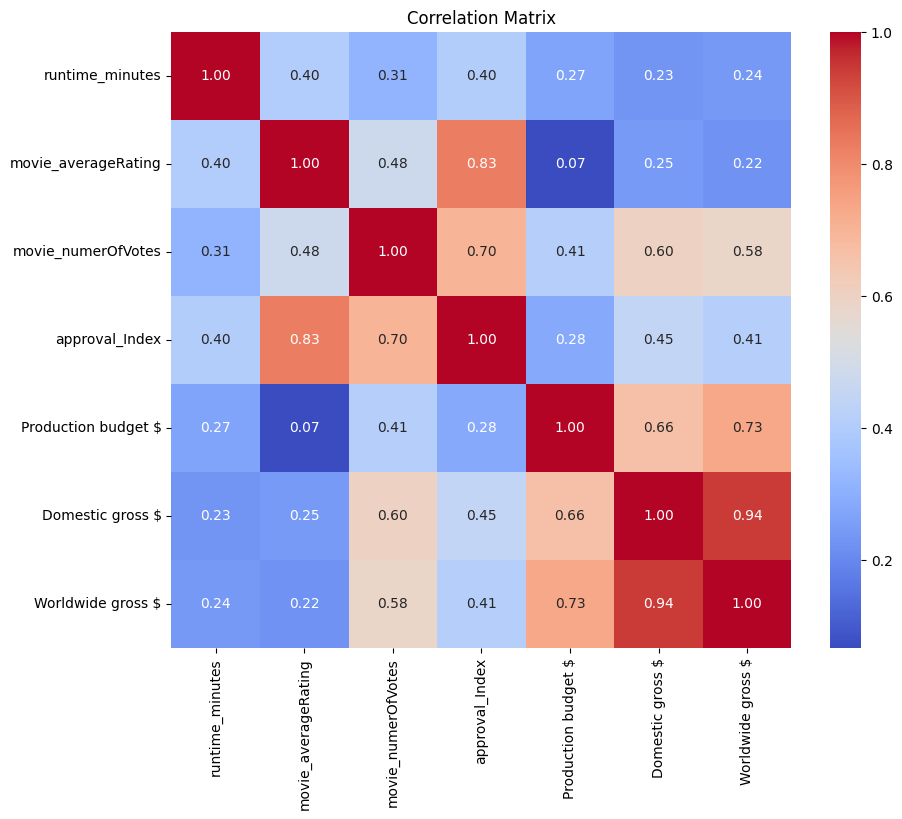

In [170]:
# Select only numerical columns
numerical_data = data.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Data Cleansing

In [171]:
# Split the 'Genre' column into separate columns without limiting the number of splits
genre_split = data['genres'].str.split(',', expand=True)

# Select only the first three genres
genre_split = genre_split.iloc[:, :3]

# Rename the new columns
genre_split.columns = ['genre1', 'genre2', 'genre3']

# Add the new columns to the original DataFrame
data = pd.concat([data, genre_split], axis=1)

# Drop the original 'Genre' column if no longer needed
data.drop(columns=['genres'], inplace=True)
data.head()

,movie_title,production_date,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,genre1,genre2,genre3
0,Avatar: The Way of Water,2022-12-09,192.0,James Cameron,"writer,producer,director",1954,alive,7.8,277543.0,7.061101,460000000,667830256,2265935552,Action,Adventure,Fantasy
1,Avengers: Endgame,2019-04-23,181.0,-,-,-,-,8.4,1143642.0,8.489533,400000000,858373000,2794731755,Action,Adventure,Drama
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,137.0,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.6,533763.0,6.272064,379000000,241071802,1045713802,Action,Adventure,Fantasy
3,Avengers: Age of Ultron,2015-04-22,141.0,Joss Whedon,"writer,producer,director",1964,alive,7.3,870573.0,7.214013,365000000,459005868,1395316979,Action,Adventure,Sci-Fi
4,Avengers: Infinity War,2018-04-25,149.0,-,-,-,-,8.4,1091968.0,8.460958,300000000,678815482,2048359754,Action,Adventure,Sci-Fi


In [172]:
# Replace all '-' with NaN
data.replace('-', np.nan, inplace=True)
data['production_date'] = pd.to_datetime(data['production_date'])
data.head()

,movie_title,production_date,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,genre1,genre2,genre3
0,Avatar: The Way of Water,2022-12-09,192.0,James Cameron,"writer,producer,director",1954,alive,7.8,277543.0,7.061101,460000000,667830256,2265935552,Action,Adventure,Fantasy
1,Avengers: Endgame,2019-04-23,181.0,NaN,NaN,NaN,NaN,8.4,1143642.0,8.489533,400000000,858373000,2794731755,Action,Adventure,Drama
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,137.0,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.6,533763.0,6.272064,379000000,241071802,1045713802,Action,Adventure,Fantasy
3,Avengers: Age of Ultron,2015-04-22,141.0,Joss Whedon,"writer,producer,director",1964,alive,7.3,870573.0,7.214013,365000000,459005868,1395316979,Action,Adventure,Sci-Fi
4,Avengers: Infinity War,2018-04-25,149.0,NaN,NaN,NaN,NaN,8.4,1091968.0,8.460958,300000000,678815482,2048359754,Action,Adventure,Sci-Fi


In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   movie_title           4380 non-null   object        
 1   production_date       4380 non-null   datetime64[ns]
 2   runtime_minutes       4380 non-null   float64       
 3   director_name         4054 non-null   object        
 4   director_professions  4047 non-null   object        
 5   director_birthYear    4054 non-null   object        
 6   director_deathYear    4054 non-null   object        
 7   movie_averageRating   4380 non-null   float64       
 8   movie_numerOfVotes    4380 non-null   float64       
 9   approval_Index        4380 non-null   float64       
 10  Production budget $   4380 non-null   int64         
 11  Domestic gross $      4380 non-null   int64         
 12  Worldwide gross $     4380 non-null   int64         
 13  genre1            

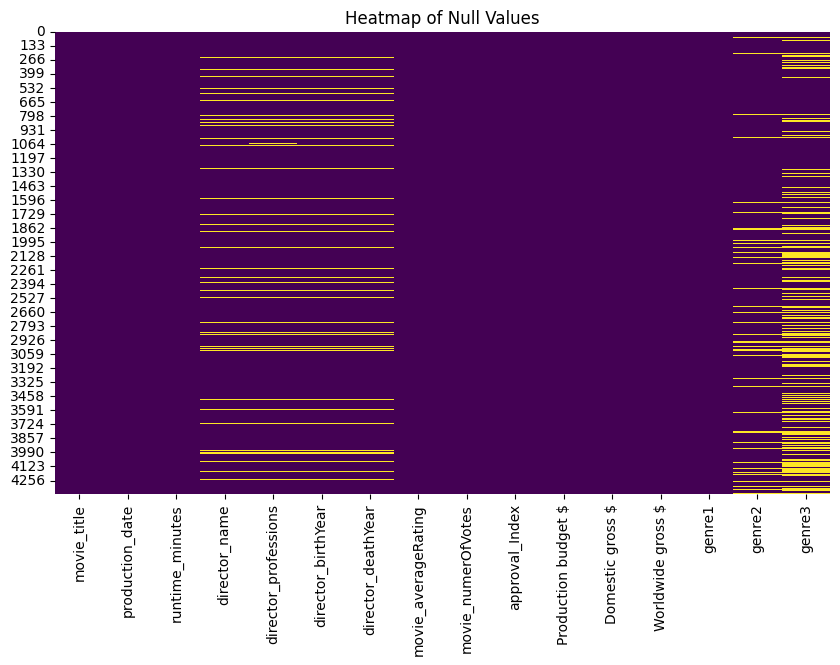

In [174]:
# Visualize the null values using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Null Values')
plt.show()

In [175]:
# Calculate the percentage of null values for each column
null_percentage = data.isnull().mean() * 100
null_percentage

movie_title              0.000000
production_date          0.000000
runtime_minutes          0.000000
director_name            7.442922
director_professions     7.602740
director_birthYear       7.442922
director_deathYear       7.442922
movie_averageRating      0.000000
movie_numerOfVotes       0.000000
approval_Index           0.000000
Production budget $      0.000000
Domestic gross $         0.000000
Worldwide gross $        0.000000
genre1                   0.000000
genre2                   8.812785
genre3                  32.602740
dtype: float64

In [176]:
# Create a new DataFrame without the 'genre1' and 'genre2' columns
new_data = data.drop(columns=['genre3', 'director_professions', 'director_name', 'director_birthYear', 'director_deathYear', 'production_date', 'movie_title'])

# Drop all rows with any null values in the new DataFrame
new_data.dropna(inplace=True)

new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994 entries, 0 to 4378
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   runtime_minutes      3994 non-null   float64
 1   movie_averageRating  3994 non-null   float64
 2   movie_numerOfVotes   3994 non-null   float64
 3   approval_Index       3994 non-null   float64
 4   Production budget $  3994 non-null   int64  
 5   Domestic gross $     3994 non-null   int64  
 6   Worldwide gross $    3994 non-null   int64  
 7   genre1               3994 non-null   object 
 8   genre2               3994 non-null   object 
dtypes: float64(4), int64(3), object(2)
memory usage: 312.0+ KB


In [177]:
new_data.nunique()

runtime_minutes         136
movie_averageRating      72
movie_numerOfVotes     3950
approval_Index         3994
Production budget $     388
Domestic gross $       3913
Worldwide gross $      3925
genre1                   16
genre2                   22
dtype: int64

In [178]:
new_data

,runtime_minutes,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,genre1,genre2
0,192.0,7.8,277543.0,7.061101,460000000,667830256,2265935552,Action,Adventure
1,181.0,8.4,1143642.0,8.489533,400000000,858373000,2794731755,Action,Adventure
2,137.0,6.6,533763.0,6.272064,379000000,241071802,1045713802,Action,Adventure
3,141.0,7.3,870573.0,7.214013,365000000,459005868,1395316979,Action,Adventure
4,149.0,8.4,1091968.0,8.460958,300000000,678815482,2048359754,Action,Adventure
...,...,...,...,...,...,...,...,...,...
4372,82.0,5.4,8561.0,3.465762,70000,30312,30312,Comedy,Drama
4373,84.0,7.3,180560.0,6.369110,68000,3221152,4678513,Drama,Horror
4376,98.0,6.6,7986.0,4.231464,50000,10426506,10426506,Comedy,Drama
4377,93.0,4.9,1593.0,2.526405,50000,2335352,2335352,Drama,Romance


### One hot encode data

In [179]:
# One-hot encode the categorical columns
df_encoded = pd.get_dummies(new_data, columns=['genre1', 'genre2']).astype(np.float32)
df_encoded

,runtime_minutes,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,genre1_Action,genre1_Adventure,genre1_Animation,...,genre2_Music,genre2_Musical,genre2_Mystery,genre2_News,genre2_Romance,genre2_Sci-Fi,genre2_Sport,genre2_Thriller,genre2_War,genre2_Western
0,192.0,7.8,277543.0,7.061101,460000000.0,667830272.0,2.265936e+09,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,181.0,8.4,1143642.0,8.489533,400000000.0,858372992.0,2.794732e+09,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,137.0,6.6,533763.0,6.272064,379000000.0,241071808.0,1.045714e+09,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,141.0,7.3,870573.0,7.214014,365000000.0,459005856.0,1.395317e+09,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,149.0,8.4,1091968.0,8.460958,300000000.0,678815488.0,2.048360e+09,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4372,82.0,5.4,8561.0,3.465762,70000.0,30312.0,3.031200e+04,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4373,84.0,7.3,180560.0,6.369110,68000.0,3221152.0,4.678513e+06,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4376,98.0,6.6,7986.0,4.231464,50000.0,10426506.0,1.042651e+07,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4377,93.0,4.9,1593.0,2.526405,50000.0,2335352.0,2.335352e+06,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Normalize Data

In [180]:
# Normalize the data using Min-Max scaling
df_min = df_encoded.min()
df_max = df_encoded.max()
df_normalized = (df_encoded - df_min) / (df_max - df_min)

df_normalized

,runtime_minutes,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,genre1_Action,genre1_Adventure,genre1_Animation,...,genre2_Music,genre2_Musical,genre2_Mystery,genre2_News,genre2_Romance,genre2_Sci-Fi,genre2_Sport,genre2_Thriller,genre2_War,genre2_Western
0,0.620192,0.818182,0.103950,0.718954,1.000000,0.778019,0.775022,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.567308,0.896104,0.428343,0.873025,0.869551,1.000000,0.955887,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.355769,0.662338,0.199916,0.633848,0.823894,0.280847,0.357667,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.375000,0.753247,0.326066,0.735447,0.793456,0.534739,0.477242,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.413462,0.896104,0.408989,0.869942,0.652136,0.790816,0.700604,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4372,0.091346,0.506494,0.003205,0.331160,0.000043,0.000035,0.000010,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4373,0.100962,0.753247,0.067626,0.644316,0.000039,0.003752,0.001600,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4376,0.168269,0.662338,0.002989,0.413749,0.000000,0.012147,0.003566,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4377,0.144231,0.441558,0.000595,0.229841,0.000000,0.002720,0.000799,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [181]:
df_normalized.describe()

,runtime_minutes,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,genre1_Action,genre1_Adventure,genre1_Animation,...,genre2_Music,genre2_Musical,genre2_Mystery,genre2_News,genre2_Romance,genre2_Sci-Fi,genre2_Sport,genre2_Thriller,genre2_War,genre2_Western
count,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,...,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.00000,3994.000000
mean,0.227176,0.637378,0.052541,0.506263,0.088116,0.063258,0.040978,0.302704,0.110165,0.005508,...,0.017276,0.005508,0.054832,0.000250,0.079119,0.024286,0.009014,0.044567,0.00651,0.003756
std,0.097531,0.131043,0.079806,0.143998,0.101566,0.089325,0.070416,0.459486,0.313135,0.074022,...,0.130314,0.074022,0.227681,0.015823,0.269958,0.153956,0.094523,0.206377,0.08043,0.061176
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.158654,0.558442,0.008942,0.414912,0.021633,0.011671,0.004944,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.211538,0.649351,0.025979,0.505316,0.054245,0.035287,0.016474,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.274038,0.727273,0.061516,0.601121,0.108599,0.076321,0.046148,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


# Model training

In [182]:
# Prepare the data
X = df_normalized.drop(columns=['Worldwide gross $'])
y = df_normalized['Worldwide gross $']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## First model

In [183]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Mean Absolute Error on test set: {mae}')

Epoch 1/50


/Users/gustavogonzalez/Universidad/OctavoSemestre/DeepLearning/Lab2/nn/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0145 - mae: 0.0829 - val_loss: 0.0014 - val_mae: 0.0226
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.4139e-04 - mae: 0.0201 - val_loss: 9.0659e-04 - val_mae: 0.0170
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.0615e-04 - mae: 0.0155 - val_loss: 7.9620e-04 - val_mae: 0.0159
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.2248e-04 - mae: 0.0145 - val_loss: 8.8035e-04 - val_mae: 0.0192
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6692e-04 - mae: 0.0145 - val_loss: 7.8191e-04 - val_mae: 0.0166
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5342e-04 - mae: 0.0136 - val_loss: 7.8668e-04 - val_mae: 0.0146
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5838e-04 - mae: 0.0139 - val_loss: 7.8027e-04 - val_mae: 0.0157
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1643e-04 - mae: 0.0132 - val_loss: 7.7265e-04 - val_mae: 0.0144
Epoch 9/50
80/80 ━━━━━━━━━

In [198]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,981 (58.52 KB)

 Trainable params: 4,993 (19.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,988 (39.02 KB)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


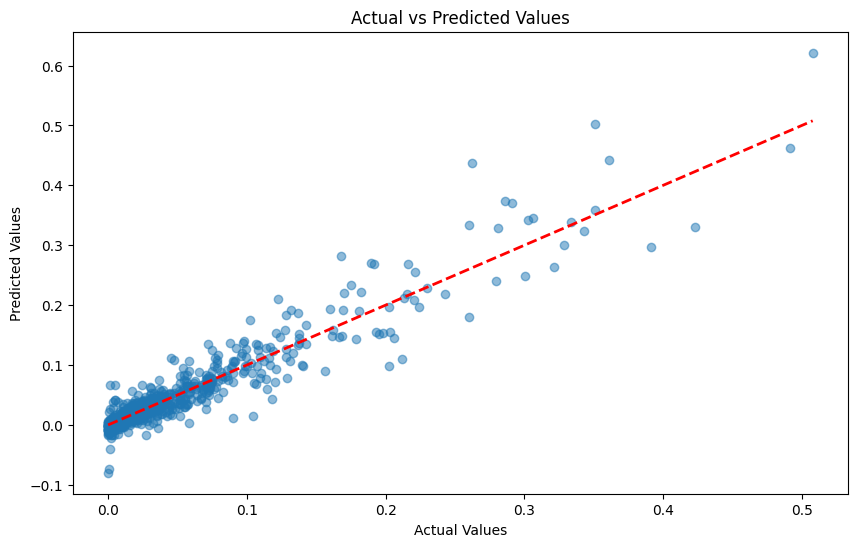

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9035e-04 - mae: 0.0139
ReLU Model - Mean Absolute Error on test set: 0.013558350503444672


In [199]:
# Predict the values on the test set
y_pred = model.predict(X_test).flatten()

# Plot the predicted values against the actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Evaluate the model
loss_relu, mae_relu = model.evaluate(X_test, y_test)
print(f'ReLU Model - Mean Absolute Error on test set: {mae_relu}')

## Second Model

In [185]:
# Variation 1: Neural Network with ReLU Activation and L2 Regularization
model_relu = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)  # Output layer for regression
])

# Compile the model
model_relu.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history_relu = model_relu.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

Epoch 1/50


/Users/gustavogonzalez/Universidad/OctavoSemestre/DeepLearning/Lab2/nn/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.1185 - mae: 0.0477 - val_loss: 0.3489 - val_mae: 0.0304
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2452 - mae: 0.0301 - val_loss: 0.0661 - val_mae: 0.0329
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0448 - mae: 0.0327 - val_loss: 0.0139 - val_mae: 0.0311
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - mae: 0.0346 - val_loss: 0.0070 - val_mae: 0.0285
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049 - mae: 0.0338 - val_loss: 0.0061 - val_mae: 0.0294
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - mae: 0.0325 - val_loss: 0.0060 - val_mae: 0.0387
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - mae: 0.0323 - val_loss: 0.0058 - val_mae: 0.0283
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0039 - mae: 0.0310 - val_loss: 0.0059 - val_mae: 0.0344
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - mae: 0.0303 - v

In [200]:
model_relu.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,245 (165.02 KB)

 Trainable params: 14,081 (55.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,164 (110.02 KB)

In [186]:
# Evaluate the model
loss_relu, mae_relu = model_relu.evaluate(X_test, y_test)
print(f'ReLU Model - Mean Absolute Error on test set: {mae_relu}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - mae: 0.0190
ReLU Model - Mean Absolute Error on test set: 0.017365889623761177


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


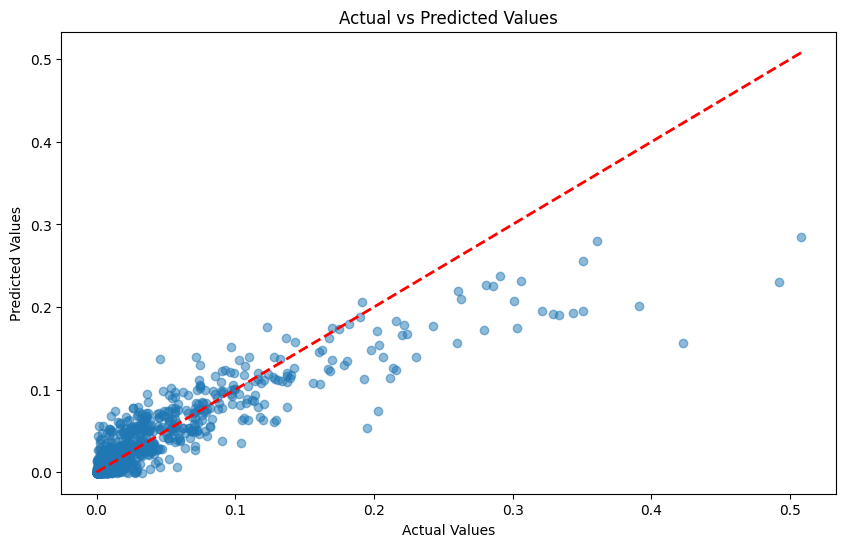

In [187]:
# Predict the values on the test set
y_pred = model_relu.predict(X_test).flatten()

# Plot the predicted values against the actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

## Third model

In [193]:
# Variation 2: Neural Network with Tanh Activation and L2 Regularization
model_tanh = Sequential([
    Dense(64, activation='tanh', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dense(32, activation='tanh', kernel_regularizer=l2(0.01)),
    Dense(1)  # Output layer for regression
])

# Compile the model
model_tanh.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history_tanh = model_tanh.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

# Evaluate the model
loss_tanh, mae_tanh = model_tanh.evaluate(X_test, y_test)
print(f'Tanh Model - Mean Absolute Error on test set: {mae_tanh}')

Epoch 1/50


/Users/gustavogonzalez/Universidad/OctavoSemestre/DeepLearning/Lab2/nn/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.8446 - mae: 0.1272 - val_loss: 0.4499 - val_mae: 0.0290
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3682 - mae: 0.0243 - val_loss: 0.1875 - val_mae: 0.0251
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1511 - mae: 0.0254 - val_loss: 0.0748 - val_mae: 0.0261
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0599 - mae: 0.0267 - val_loss: 0.0308 - val_mae: 0.0245
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0241 - mae: 0.0264 - val_loss: 0.0144 - val_mae: 0.0285
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0115 - mae: 0.0286 - val_loss: 0.0088 - val_mae: 0.0267
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - mae: 0.0288 - val_loss: 0.0067 - val_mae: 0.0291
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - mae: 0.0294 - val_loss: 0.0060 - val_mae: 0.0275
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - mae: 0.0290 - v

In [201]:
model_tanh.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 64)             │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,981 (58.52 KB)

 Trainable params: 4,993 (19.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,988 (39.02 KB)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


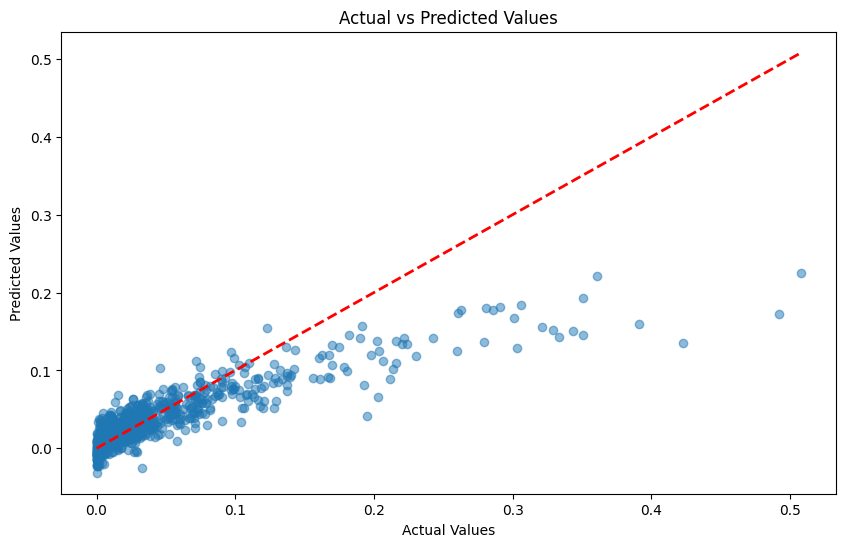

In [194]:
# Predict the values on the test set
y_pred = model_tanh.predict(X_test).flatten()

# Plot the predicted values against the actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

## Fourth Model

In [196]:
# Variation 4: Neural Network with Tanh Activation and L1 Regularization
model_l1 = Sequential([
    Dense(64, activation='tanh', kernel_regularizer=l1(0.01), input_shape=(X_train.shape[1],)),
    Dense(32, activation='tanh', kernel_regularizer=l1(0.01)),
    Dense(1)  # Output layer for regression
])

# Compile the model
model_tanh.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history_tanh = model_tanh.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

# Evaluate the model
loss_tanh, mae_tanh = model_tanh.evaluate(X_test, y_test)
print(f'Mean Absolute Error on test set: {mae_tanh}')

Epoch 1/50


/Users/gustavogonzalez/Universidad/OctavoSemestre/DeepLearning/Lab2/nn/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0165 - mae: 0.0426 - val_loss: 0.0113 - val_mae: 0.0429
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0098 - mae: 0.0403 - val_loss: 0.0123 - val_mae: 0.0385
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0093 - mae: 0.0386 - val_loss: 0.0115 - val_mae: 0.0373
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0097 - mae: 0.0404 - val_loss: 0.0120 - val_mae: 0.0408
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0102 - mae: 0.0415 - val_loss: 0.0116 - val_mae: 0.0390
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0105 - mae: 0.0438 - val_loss: 0.0113 - val_mae: 0.0368
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0098 - mae: 0.0423 - val_loss: 0.0128 - val_mae: 0.0389
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0099 - mae: 0.0413 - val_loss: 0.0117 - val_mae: 0.0446
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0095 - mae: 0.0418 - v

In [202]:
model_l1.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 64)             │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,993 (19.50 KB)

 Trainable params: 4,993 (19.50 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


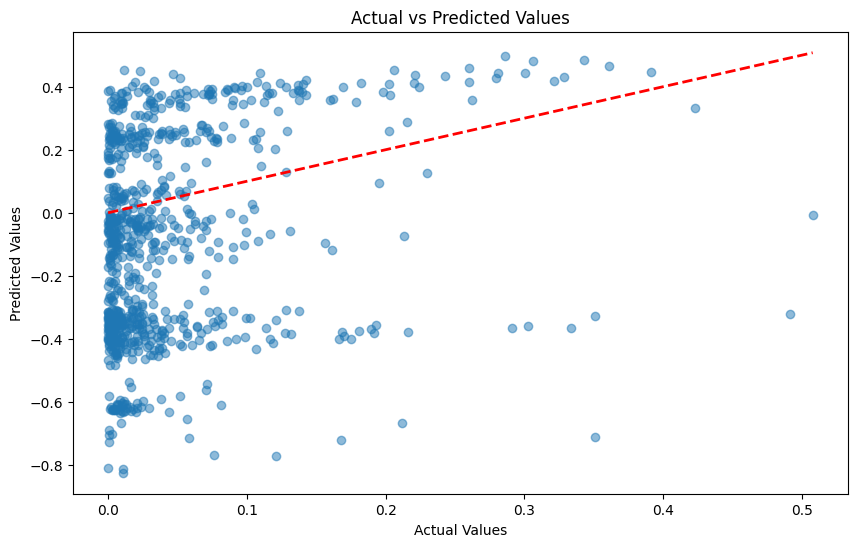

In [197]:
# Predict the values on the test set
y_pred = model_l1.predict(X_test).flatten()

# Plot the predicted values against the actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()